## Data analysis of Amazon dataset, prediction of user rating

Amazon.com, Inc. is an American multinational technology company which focuses on e-commerce, cloud computing, digital streaming, and artificial intelligence.  amazon.com is the world's largest online marketplace, which offers customers variety of different products to buy and ship to any location.

This notebook is made to analyse data from Amazon top 50 bestselling books from 2009 to 2019.

Dataset was taken from https://www.kaggle.com/sootersaalu/amazon-top-50-bestselling-books-2009-2019

![Amazon Logo](https://www.kamexport41.ru/upload/iblock/841/amazon.jpg)


Importing libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
%matplotlib inline
pd.set_option('display.max_rows', None)
pd.options.display.max_colwidth = None
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, RobustScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error


In [2]:
df = pd.read_csv('bestsellers with categories.csv')
df.head()

,Name,Author,User Rating,Reviews,Price,Year,Genre
0,10-Day Green Smoothie Cleanse,JJ Smith,4.7,17350,8,2016,Non Fiction
1,11/22/63: A Novel,Stephen King,4.6,2052,22,2011,Fiction
2,12 Rules for Life: An Antidote to Chaos,Jordan B. Peterson,4.7,18979,15,2018,Non Fiction
3,1984 (Signet Classics),George Orwell,4.7,21424,6,2017,Fiction
4,"5,000 Awesome Facts (About Everything!) (National Geographic Kids)",National Geographic Kids,4.8,7665,12,2019,Non Fiction


Delete null values

In [3]:
df.isnull().sum()

Name           0
Author         0
User Rating    0
Reviews        0
Price          0
Year           0
Genre          0
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         550 non-null    object 
 1   Author       550 non-null    object 
 2   User Rating  550 non-null    float64
 3   Reviews      550 non-null    int64  
 4   Price        550 non-null    int64  
 5   Year         550 non-null    int64  
 6   Genre        550 non-null    object 
dtypes: float64(1), int64(3), object(3)
memory usage: 30.2+ KB


In [5]:
df.describe()

,User Rating,Reviews,Price,Year
count,550.000000,550.000000,550.000000,550.000000
mean,4.618364,11953.281818,13.100000,2014.000000
std,0.226980,11731.132017,10.842262,3.165156
min,3.300000,37.000000,0.000000,2009.000000
25%,4.500000,4058.000000,7.000000,2011.000000
50%,4.700000,8580.000000,11.000000,2014.000000
75%,4.800000,17253.250000,16.000000,2017.000000
max,4.900000,87841.000000,105.000000,2019.000000


### Encoding genres

In [6]:
data = pd.get_dummies(df, columns=['Genre'])
data = data.rename({'Genre_Fiction':'Fiction','Genre_Non Fiction':'Non Fiction'},axis=1)

In [7]:
data = data.groupby(['Name','Author']).agg({'User Rating':'mean',
    'Reviews':'max',
    'Price':'mean',
    'Non Fiction':'first',
    'Fiction':'first'
}).reset_index()

Let's distribution of book ratings in dataset.

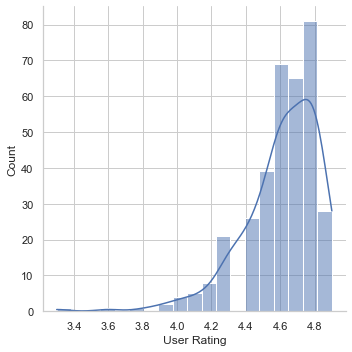

In [8]:
sns.displot(data['User Rating'], kde = True)
plt.show()

### How much books there are by genres

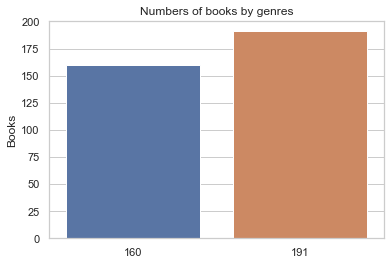

In [9]:
books_by_genre = data[['Fiction','Non Fiction']].sum()
sns.barplot(x=books_by_genre.index, y=books_by_genre.values, data=books_by_genre)
plt.title('Numbers of books by genres')
plt.ylabel('Books')
plt.show()

### Average of books by year

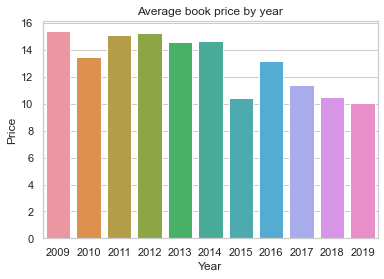

In [10]:
price_by_year = df[['Price','Year']].groupby('Year').mean().reset_index()
sns.barplot(x='Year', y = 'Price', data=price_by_year)
plt.title('Average book price by year')
plt.show()

### Price distribution

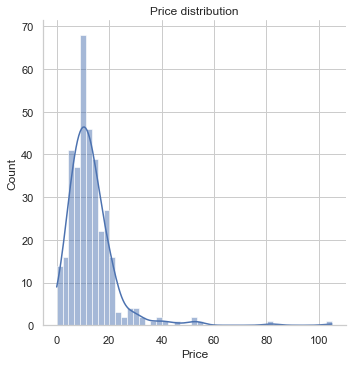

In [11]:
sns.displot(data['Price'], kde = True)
plt.title('Price distribution')
plt.show()

### 10 most popular authors from 2009 to 2019

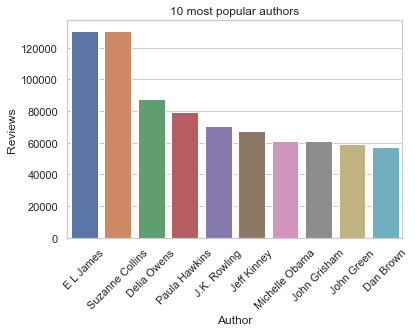

In [12]:
authors_by_reviews = data[['Author','Reviews']].groupby('Author').sum().reset_index().sort_values(by='Reviews', ascending=False)[:10]
sns.barplot(x='Author', y = 'Reviews', data=authors_by_reviews)
plt.xticks(rotation=45)
plt.title('10 most popular authors')
plt.show()

### Top 15 most popular books from 2009 to 2019

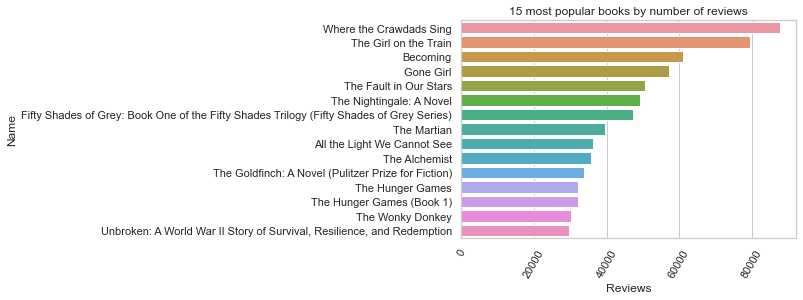

In [13]:
books_by_reviews = data[['Name','Reviews']].sort_values(by='Reviews', ascending=False)[:15]
sns.barplot(x='Reviews', y ='Name' , data=books_by_reviews, orient='h')

plt.xticks(rotation=60)
plt.title('15 most popular books by number of reviews')
plt.show()

### Top 15 most expensive books

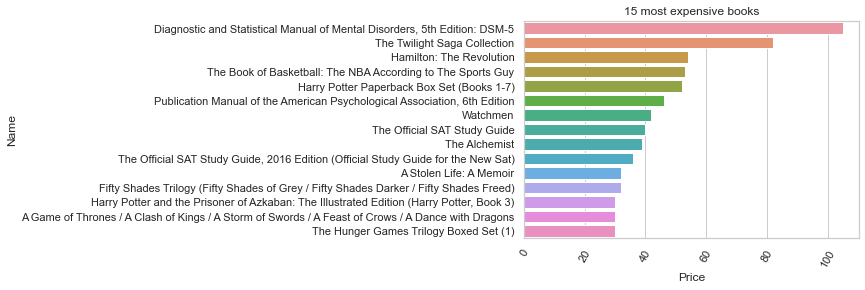

In [14]:
books_by_price = data[['Name','Price']].sort_values(by='Price', ascending=False)[:15]
sns.barplot(x='Price', y ='Name' , data=books_by_price, orient='h')

plt.xticks(rotation=60)
plt.title('15 most expensive books')
plt.show()

### Correlation matrix

Let's look if any genres correlate with each other

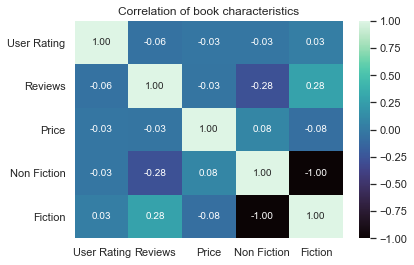

In [15]:
sns.heatmap(data.corr(), annot=True, fmt='.2f', cmap="mako")
plt.title('Correlation of book characteristics')
plt.show()


As we see, there is no significant correlation, except in genres, which was obvious.

Let's look if user rating, reviews and price distributions of books have any significant outliers

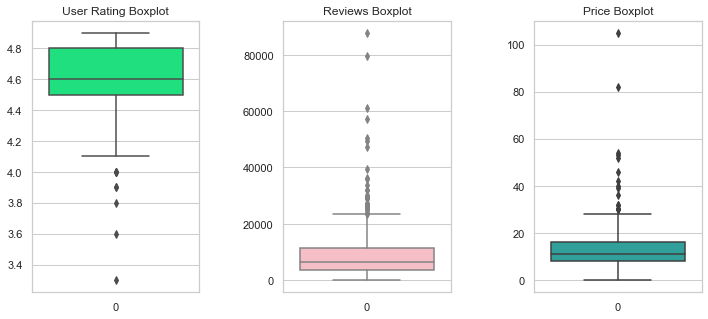

In [16]:
cols = ['User Rating','Reviews', 'Price']
colors = ['springgreen','lightpink','lightseagreen']
outlier_data = data[cols]

plt.figure(figsize=(12,5))
plt.subplots_adjust(wspace=0.5)

i=1
for col in cols:
    plt.subplot(1,3,i)
    sns.boxplot(data=outlier_data[col],color=colors[i-1])
    plt.title(f'{col} Boxplot')
    i+=1

plt.show()

## Predicting user rating, comparing different regression algorithms with different scalers

Our goal in this analysis is to predict user rating of books. To make our model more precise we will use regression algorithms such as Linear, Ridge, Lasso and ElasticNet regression algorithms and try out different scalers to determine if change in method of scaling will yield better results.

### Encoding

Let's encode authors using label encoder.

In [17]:
le = LabelEncoder()
data['Author'] = le.fit_transform(data['Author'])
data.head()

,Name,Author,User Rating,Reviews,Price,Non Fiction,Fiction
0,10-Day Green Smoothie Cleanse,114,4.7,17350,8.0,1,0
1,11/22/63: A Novel,219,4.6,2052,22.0,0,1
2,12 Rules for Life: An Antidote to Chaos,134,4.7,18979,15.0,1,0
3,1984 (Signet Classics),95,4.7,21424,6.0,0,1
4,"5,000 Awesome Facts (About Everything!) (National Geographic Kids)",174,4.8,7665,12.0,1,0


In [18]:
def get_error(model, X_test, y_test, scaler_name):

    y_pred = model.predict(X_test)
    results = {'Model':model.__class__.__name__,
    'Scaler': scaler_name,
    'MSE': mean_squared_error(y_test,y_pred),
    'RMSE': mean_squared_error(y_test,y_pred,squared=False),
    'MAE': mean_absolute_error(y_test,y_pred)}
    df = pd.DataFrame.from_dict(results.values()).T
    df.columns = results.keys()

    return df

In [34]:
def get_results(scaler, data=data):

    X = data.drop(['Name','User Rating'], axis=1)
    y = data['User Rating']

    if scaler:
        scaler_name=scaler.__class__.__name__

        X['Reviews'] = scaler.fit_transform(X[['Reviews', 'Reviews']])

        X['Price'] = scaler.fit_transform(X[['Price', 'Price']])

        
    else:
        scaler_name = 'None'

    X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)
    
    lr = LinearRegression().fit(X_train,y_train)
    df = get_error(lr, X_test,y_test,scaler_name)

    rr = Ridge().fit(X_train,y_train)
    df = df.append(get_error(rr, X_test,y_test,scaler_name))

    lsr = Lasso().fit(X_train,y_train)
    df = df.append(get_error(lsr, X_test,y_test,scaler_name))

    elr = ElasticNet().fit(X_train,y_train)
    df = df.append(get_error(elr, X_test,y_test,scaler_name))

    return df


In [32]:
result_df = get_results(None)
result_df

,Model,Scaler,MSE,RMSE,MAE
0,LinearRegression,None,0.054071,0.232531,0.182114
0,Ridge,None,0.054072,0.232535,0.182121
0,Lasso,None,0.054083,0.232558,0.181842
0,ElasticNet,None,0.054088,0.232567,0.181855


As we see, without any scaling, models yield very close results. Surprisingly, classical linear regression has the best accuracy.

As scalers to try out we will use next ones: 
* StandardScaler 
* MaxAbsScaler
* MinMaxScaler
* RobustScaler

In [36]:
scalers = [StandardScaler(),MaxAbsScaler(),MinMaxScaler(),RobustScaler()]
for scaler in scalers:
    result_df = result_df.append(get_results(scaler))

ValueError: Expected 2D array, got 1D array instead:
array=[1.7350e+04 2.0520e+03 1.8979e+04 2.1424e+04 7.6650e+03 1.2643e+04
 1.9735e+04 1.9699e+04 5.9830e+03 2.3848e+04 4.6000e+02 4.1490e+03
 5.1530e+03 5.0130e+03 2.3130e+03 2.9250e+03 2.9510e+03 2.4260e+03
 9.1980e+03 3.6348e+04 6.3100e+03 1.5921e+04 1.2159e+04 7.9800e+02
 9.3740e+03 4.9100e+02 5.3600e+03 1.9090e+03 1.2960e+03 6.1500e+02
 6.1133e+04 1.1113e+04 1.0070e+04 3.7290e+03 9.7690e+03 4.7100e+02
 1.4344e+04 4.5050e+03 1.0369e+04 1.6244e+04 2.8840e+03 2.2614e+04
 4.7610e+03 1.5420e+03 6.1430e+03 4.0220e+03 3.8710e+03 4.8660e+03
 1.3290e+03 4.6420e+03 1.5410e+03 2.0940e+03 1.9240e+03 1.0922e+04
 2.1370e+03 1.6510e+03 6.6790e+03 6.8120e+03 3.8370e+03 6.5400e+03
 7.9550e+03 2.7098e+04 1.7684e+04 3.7000e+01 1.5845e+04 3.1810e+03
 5.0620e+03 4.7860e+03 7.2350e+03 1.2619e+04 9.0890e+03 5.4700e+03
 5.1180e+03 2.1340e+03 2.5250e+03 7.2000e+02 9.5600e+02 6.3460e+03
 5.5050e+03 5.5050e+03 2.8729e+04 5.4130e+03 1.0721e+04 4.3700e+03
 6.0420e+03 2.3631e+04 2.0262e+04 1.3964e+04 4.7265e+04 1.3677e+04
 1.7323e+04 1.5550e+03 3.6420e+03 1.2150e+03 5.5940e+03 4.0800e+02
 4.7990e+03 1.4038e+04 7.6600e+03 2.2288e+04 1.3650e+03 1.4982e+04
 9.5680e+03 1.6360e+03 5.7271e+04 1.0141e+04 3.4570e+03 8.8370e+03
 7.0380e+03 5.9720e+03 2.5624e+04 5.4760e+03 5.8670e+03 4.1480e+03
 3.5640e+03 1.3471e+04 1.9622e+04 2.3973e+04 7.7580e+03 3.1460e+03
 1.0052e+04 1.9300e+03 1.5779e+04 1.5526e+04 3.7760e+03 2.5001e+04
 5.2720e+03 3.4900e+03 2.8120e+03 4.8960e+03 9.7370e+03 1.3200e+03
 1.6643e+04 7.1530e+03 4.5710e+03 2.9651e+04 5.2990e+03 7.3960e+03
 7.0620e+03 9.7800e+02 1.9576e+04 4.7480e+03 8.3930e+03 1.1391e+04
 8.6340e+03 9.3420e+03 1.0927e+04 5.2350e+03 8.9160e+03 2.5070e+03
 3.6730e+03 1.1881e+04 6.9900e+03 6.1320e+03 3.0140e+03 7.5500e+03
 3.8280e+03 2.7520e+03 1.4670e+03 1.8840e+03 2.5706e+04 8.4910e+03
 1.6490e+03 1.8613e+04 9.8670e+03 1.3860e+03 1.0199e+04 2.9260e+03
 1.7739e+04 3.1130e+03 5.5420e+03 2.6741e+04 5.3470e+03 7.8660e+03
 5.6800e+03 5.1780e+03 8.0930e+03 3.1920e+03 2.1834e+04 6.1690e+03
 4.5190e+03 3.1630e+03 1.8310e+03 1.8904e+04 2.1930e+04 1.0426e+04
 1.0820e+04 5.4800e+02 1.6990e+04 3.5030e+03 1.3616e+04 8.5800e+03
 4.7570e+03 1.0009e+04 1.9850e+03 2.2536e+04 7.1500e+03 3.8360e+03
 7.8020e+03 3.6190e+03 2.3047e+04 9.3660e+03 1.2650e+03 3.9230e+03
 2.2720e+03 9.7300e+02 2.2000e+02 7.8270e+03 9.3820e+03 5.0690e+03
 1.5830e+03 1.9070e+03 2.3114e+04 6.3700e+02 2.3140e+03 4.5870e+03
 3.4770e+03 2.5554e+04 1.6800e+03 9.3250e+03 3.5799e+04 2.5800e+03
 1.1813e+04 3.5360e+03 1.7890e+03 6.6000e+03 1.2361e+04 2.3148e+04
 8.5800e+02 8.0810e+03 2.3358e+04 9.3720e+03 4.6330e+03 1.3061e+04
 3.5230e+03 2.7740e+03 4.4000e+02 8.9220e+03 2.0230e+03 1.8590e+03
 5.0482e+04 3.2070e+03 8.0300e+02 2.3308e+04 5.8360e+03 7.7470e+03
 7.2510e+03 7.2510e+03 7.9446e+04 1.0559e+04 5.2490e+03 3.3844e+04
 1.1616e+04 1.3609e+04 8.5870e+03 2.9442e+04 1.1098e+04 9.9470e+03
 1.3871e+04 6.9820e+03 3.2122e+04 3.2122e+04 1.6949e+04 9.2890e+03
 7.3680e+03 4.0280e+03 4.6280e+03 5.3960e+03 4.2470e+03 2.2641e+04
 6.2220e+03 4.5060e+03 8.7470e+03 1.6550e+03 7.8610e+03 6.2470e+03
 3.9459e+04 1.0101e+04 5.8980e+03 2.7440e+03 4.9288e+04 1.2010e+03
 8.0700e+02 3.7590e+03 2.6630e+03 3.4280e+03 2.8760e+03 3.6010e+03
 7.0580e+03 9.7840e+03 1.0795e+04 1.0191e+04 1.4493e+04 2.1860e+03
 1.2040e+03 2.0910e+03 1.9720e+04 2.1220e+03 2.7536e+04 4.2900e+03
 2.6490e+04 5.4870e+03 6.3770e+03 1.4630e+03 3.7590e+03 3.5030e+03
 1.1550e+04 3.8010e+03 3.7960e+03 9.0300e+03 1.9546e+04 7.5080e+03
 8.8420e+03 3.0183e+04 6.1690e+03 7.0340e+03 1.1034e+04 7.9320e+03
 1.9040e+03 3.3190e+03 1.1128e+04 5.9770e+03 2.6234e+04 4.3600e+03
 2.2820e+03 4.3800e+02 1.1676e+04 2.5860e+03 2.9673e+04 6.7400e+03
 5.9560e+03 6.1080e+03 4.5850e+03 3.8290e+03 8.9580e+03 5.4920e+03
 9.2920e+03 1.8730e+03 8.1700e+03 3.3410e+03 7.4970e+03 1.3779e+04
 8.7841e+04 9.9670e+03 6.6690e+03 1.7044e+04 1.0760e+04 1.3020e+03
 2.1625e+04 9.4130e+03 1.4331e+04].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
result_df.sort_values(['MSE','RMSE','MAE'])

,Model,Scaler,MSE,RMSE,MAE
0,LinearRegression,None,0.054071,0.232531,0.182114
0,Ridge,None,0.054072,0.232535,0.182121
0,Lasso,None,0.054083,0.232558,0.181842
0,ElasticNet,None,0.054088,0.232567,0.181855


As we can see, using scalers 8 accuracy results was the same. To be more precise, Lasso regression and ElasticNEt regression algorithms using any of the scalers got the best results. 